# In this notebook we'll look at MC dropout / ensembles to model epistemic uncertainty in NNs
https://arxiv.org/pdf/1506.02142.pdf
https://proceedings.neurips.cc/paper/2017/file/9ef2ed4b7fd2c810847ffa5fa85bce38-Paper.pdf

In [51]:
import matplotlib.pyplot as plt
import random
import numpy as np

import torch
from torch.utils.data import DataLoader, Dataset
from torch import nn
from torch import optim
from torchsummary import summary

import GPy

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
# Generate data set from test function
def func(x, sig):
    return x**3.0 + np.random.normal(0, sig, size=x.shape)

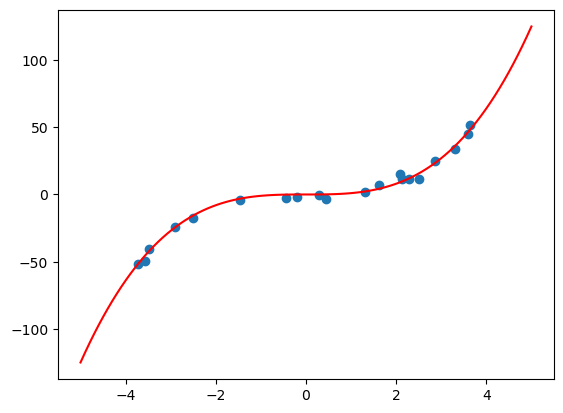

In [14]:
# Plot result
x = np.random.uniform(-4, 4, 20)
y = func(x, 3.0)
x_true = np.linspace(-5, 5, 100)
y_true = x_true**3
plt.plot(x_true, y_true, color='red')
plt.scatter(x, y)
plt.show()

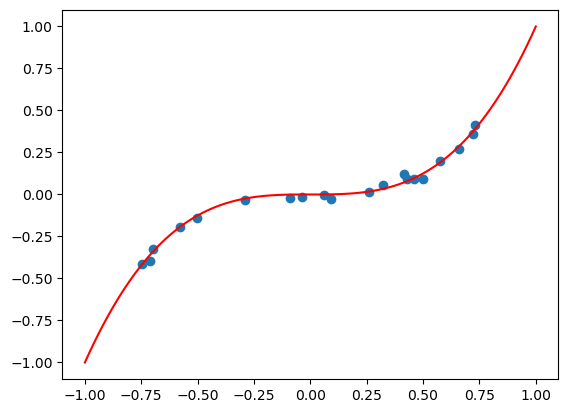

In [15]:
# Normalise data (symmetric around zero so just divide by max)
x = x / np.max(x_true)
y = y / np.max(y_true)
x_true = x_true / np.max(x_true)
y_true = y_true / np.max(y_true)
plt.plot(x_true, y_true, color='red')
plt.scatter(x, y)
plt.show()

# Before looking at uncertainty in deep learning models, we will quickly apply a Gaussian process to the data (gold standard for bayesian regression tasks)

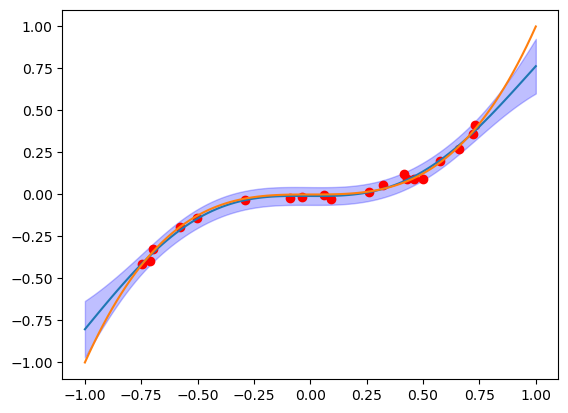

In [54]:
kernel = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)
m = GPy.models.GPRegression(x[:, None],y[:,None],kernel)
m.optimize(messages=True)
y_pred, y_var = m.predict(x_true[:, None])

fig, ax = plt.subplots()
ax.plot(x_true, y_pred)
ax.fill_between(x_true, (y_pred - 2 * y_var**0.5)[:,0], (y_pred + 2 * y_var**0.5)[:, 0], alpha=0.25, color='blue')
ax.scatter(x,y, color='red')
ax.plot(x_true, y_true)
plt.show()

# We'll start by training a vanilla, single hidden layer NN

In [16]:
# Define model
class SingleLayerNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 1000),
            nn.ReLU(),
            nn.Linear(1000, 1))
    
    def forward(self, x):
        return self.net(x)

# Define optimiser / loss
model = SingleLayerNN()
opt = torch.optim.Adam(params=model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

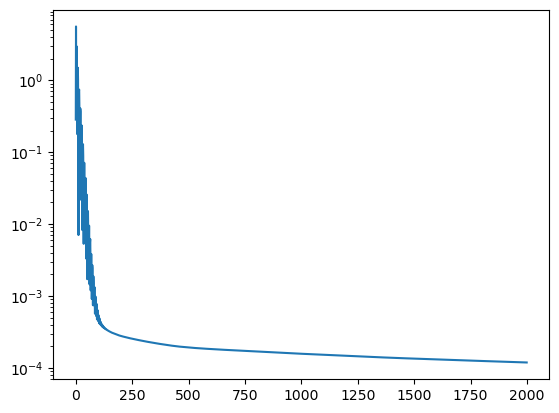

0.28408128023147583 0.00011896539945155382


In [17]:
epochs = 2000
x_torch = torch.tensor(x[:,None], dtype=torch.float)
y_torch = torch.tensor(y[:,None], dtype=torch.float)

losses = []
for i in range(epochs):
    # zero the parameter gradients
    opt.zero_grad()
    # forward + backward + optimize
    y_pred = model(x_torch)
    loss = loss_fn(y_pred, y_torch)
    loss.backward()
    opt.step()
    losses.append(loss.item())
    
plt.semilogy(losses)
plt.show()
print(losses[0], losses[-1])

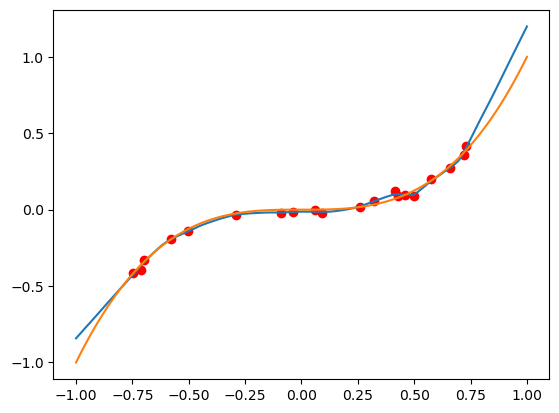

In [18]:
model.eval()
with torch.no_grad():
    y_pred = model(torch.tensor(x_true[:,None], dtype=torch.float))
    
plt.plot(x_true, y_pred.numpy())
plt.plot(x_true, y_true)
plt.scatter(x,y, color='red')
plt.show()

## This does a faily good job within dataset but bad outside with no uncertainty.

# We'll now train a similar network capable of estimating the aleatoric uncertainty.

In [19]:
# Same network as before but now return two values for mean / varaince 
class NllModel(nn.Module):
    def __init__(self,):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 1000),
            nn.ReLU(),
            nn.Linear(1000, 2))
        
    def forward(self, x):
        y = self.net(x)
        mean, sig = torch.split(y, 1, dim=1)
        return mean, sig**2.0

# Define optimiser / loss (Now we are using Gaussian negative log likelihood loss)
model = NllModel()
opt = torch.optim.Adam(params=model.parameters(), lr=0.0001)
loss_fn = nn.GaussianNLLLoss(eps=1e-4)

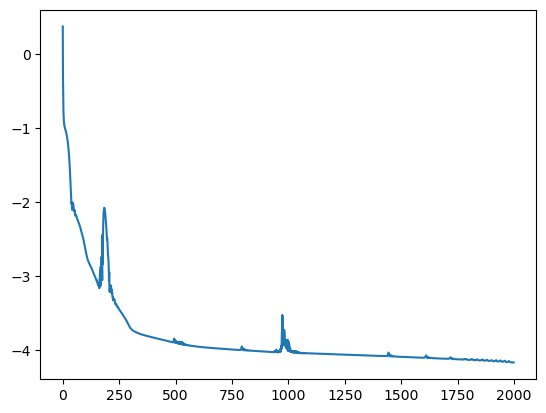

0.3751576542854309 -4.164442539215088


In [20]:
epochs = 2000
x_torch = torch.tensor(x[:,None], dtype=torch.float)
y_torch = torch.tensor(y[:,None], dtype=torch.float)

losses = []
for i in range(epochs):
    # zero the parameter gradients
    opt.zero_grad()
    # forward + backward + optimize
    mean, var = model(x_torch)
    loss = loss_fn(mean, y_torch, var)
    loss.backward()
    opt.step()
    losses.append(loss.item())
    
plt.plot(losses)
plt.show()
print(losses[0], losses[-1])

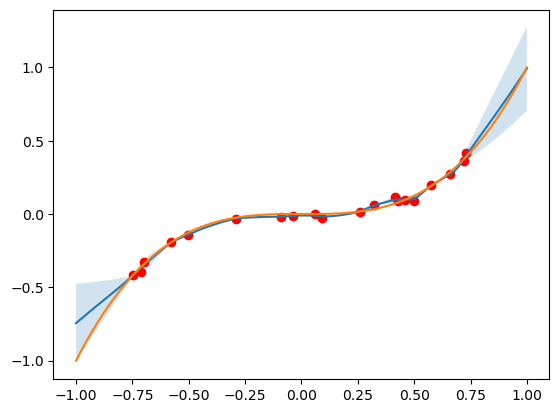

In [21]:
with torch.no_grad():
    y_pred, var_pred = model(torch.tensor(x_true[:,None], dtype=torch.float))

mean = y_pred.numpy()[:,0]
sig = (var_pred.numpy()**0.5)[:,0]
plt.plot(x_true, mean)
plt.fill_between(x_true, mean - 2*sig, mean + 2*sig, alpha=0.2)
plt.plot(x_true, y_true)
plt.scatter(x,y, color='red')
plt.show()

# We'll now train an ensemble of networks giving an estimate of the epistemic uncertanty.

In [31]:
class EnsambleModel(nn.Module):
    def __init__(self, n_networks, inputs, targets):
        self.n_networks = n_networks
        self.inputs = inputs
        self.targets = targets
        
        self.networks = []
        self.opt = []
        self.loss_fn = []
        for i in range(self.n_networks):
            self.networks.append(NllModel())
            self.opt.append(torch.optim.Adam(
                params=self.networks[i].parameters(), lr=0.0001))
            self.loss_fn.append(nn.GaussianNLLLoss(eps=1e-4))
            
    def forward(self, x):
        net_means = torch.zeros((x.shape[0], self.n_networks))
        net_vars = torch.zeros((x.shape[0], self.n_networks))
        
        for i in range(self.n_networks):
            mean, var = self.networks[i](x)
            net_means[:, i], net_vars[:,i] = torch.squeeze(mean), torch.squeeze(var)
        
        mean = torch.mean(net_means, axis=1)
        var = torch.mean(net_vars + net_means**2.0, axis=1) - mean**2.0
        return mean, var
       

    def train(self, epochs, plot=False):
        """
        Basic training function.
        """
        
        # Loop networks
        for i in range(self.n_networks):
            losses = []
            # Loop epochs
            for j in range(epochs):
                # zero the parameter gradients
                self.opt[i].zero_grad()

                # forward + backward + optimize
                mean, var = self.networks[i](self.inputs)
                loss = self.loss_fn[i](mean, self.targets, var)
                loss.backward()
                self.opt[i].step()
                losses.append(loss.item())
            
            if plot:
                fig, ax = plt.subplots()
                ax.plot(losses)
        
        
    def train_adversarial(self, epochs, eps, plot=False):
        """
        Training function which using adversarial method. See: "Simple and Scalable Predictive 
        Uncertainty Estimation using Deep Ensembles"
        epochs: number of training steps
        eps: Adversarial gradient step size
        """
        
        if not self.inputs.requires_grad:
            raise Exception("Error: Gradient of loss w.r.t input required")
        
        if plot:
            fig, ax = plt.subplots()
        # Loop networks
        for i in range(self.n_networks):
            losses = []
            # Loop epochs
            for j in range(epochs):
                # First calculate new points
                self.opt[i].zero_grad()
                mean, var = self.networks[i](self.inputs)
                loss = self.loss_fn[i](mean, y_torch, var)
                loss.backward()
                inputs_p = self.inputs + eps * torch.sign(self.inputs.grad.data)

                # calc gradients for both new and old input (gradients are summed)
                mean, var = self.networks[i](inputs_p)
                loss = self.loss_fn[i](mean, self.targets, var)
                loss.backward()

                self.opt[i].step()
                losses.append(loss.item())
            
            if plot:
                ax.plot(losses)
                

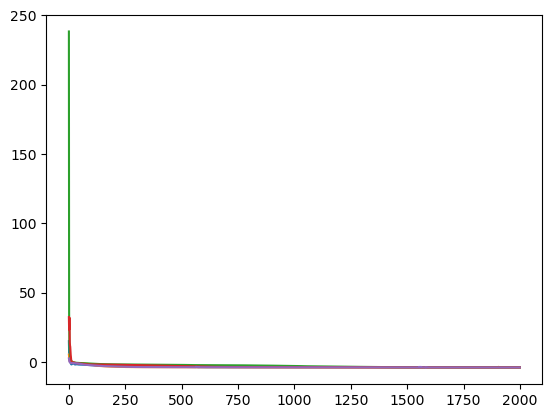

In [37]:
x_torch.requires_grad = True
model = EnsambleModel(5, x_torch, y_torch)
model.train_adversarial(2000, 0.01, True)
plt.show()

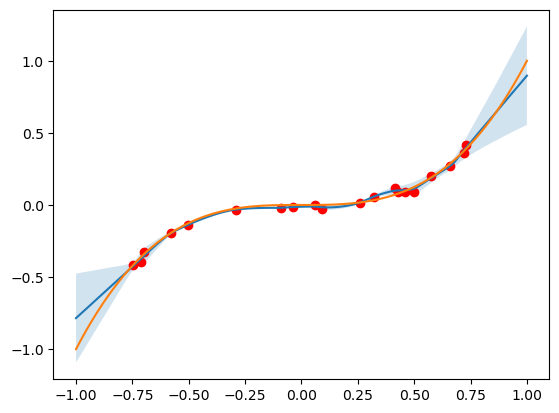

In [39]:
model.eval()
with torch.no_grad():
    y_pred, var_pred = model.forward(torch.tensor(x_true[:,None], dtype=torch.float))
mean = y_pred.numpy()
sig = (var_pred.numpy()**0.5)
plt.plot(x_true, mean)
plt.fill_between(x_true, mean - 2.0*sig, mean + 2.0*sig, alpha=0.2)
plt.plot(x_true, y_true)
plt.scatter(x,y, color='red')
plt.show()

# Finally, we'll train a network using MC dropout as a Baysian approximation for the epistemic uncertainty.

In [41]:
class McModel(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 1000),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(1000, 1))
    
    def forward(self, x):
        return self.net(x)
    
model = McModel()
opt = torch.optim.Adam(params=model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

0.08933262526988983 0.0012671626172959805


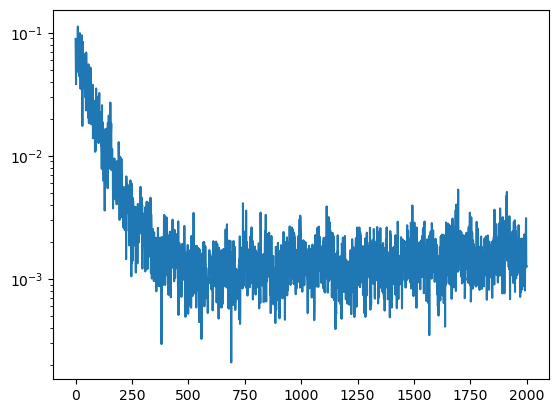

In [42]:
epochs = 2000
x_torch = torch.tensor(x[:,None], dtype=torch.float)
y_torch = torch.tensor(y[:,None], dtype=torch.float)

losses = []
for i in range(epochs):
    # zero the parameter gradients
    opt.zero_grad()    
    # forward + backward + optimize
    y_pred = model(x_torch)
    loss = loss_fn(y_pred, y_torch)
    loss.backward()
    opt.step()
    losses.append(loss.item())
    
plt.semilogy(losses)
print(losses[0], losses[-1])
plt.show()

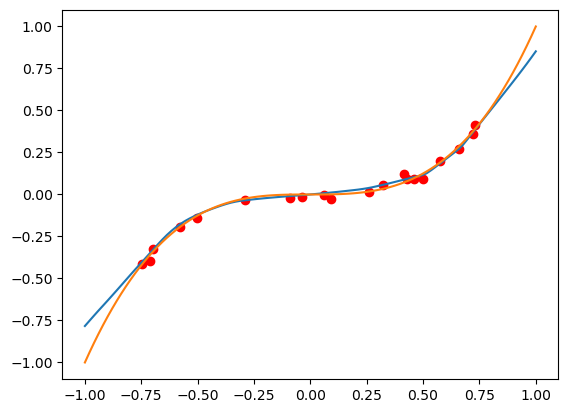

In [43]:
# Check the single pass result 
model.eval()
with torch.no_grad():
    y_pred = model(torch.tensor(x_true[:,None], dtype=torch.float))
    
plt.plot(x_true, y_pred.numpy())
plt.plot(x_true, y_true)
plt.scatter(x,y, color='red')
plt.show()

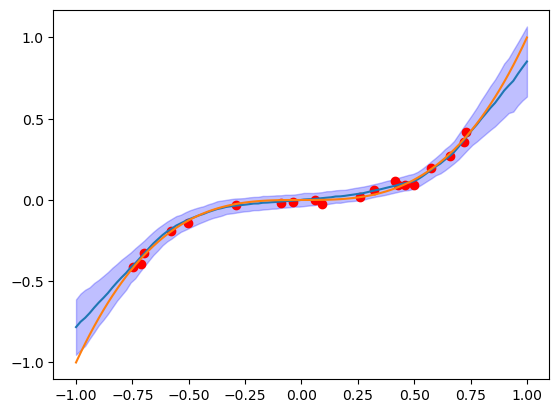

In [47]:
# Now use mulitple samples to estimate uncertanty
model.train()
samples = 1000
with torch.no_grad():
    x_input = torch.tensor(x_true[:,None], dtype=torch.float).repeat(1,samples).flatten()[:,None]
    y_pred = model(x_input).reshape((x_true.shape[0], samples))
    y_mean = torch.mean(y_pred, axis=1)
    y_var = torch.var(y_pred, axis=1)
    
plt.plot(x_true, y_mean.numpy())
plt.fill_between(x_true, y_mean.numpy()-2.0*y_var.numpy()**0.5, y_mean.numpy()+2.0*y_var.numpy()**0.5, alpha=0.25, color='blue')
plt.plot(x_true, y_true)
plt.scatter(x,y, color='red')

plt.show()